# Project-008-2 Heart Disease 

### Predicting Heart Disease Diagnosis

### Introduction 

The cardiovascular system encompasses an intricate network of blood vessels that facilitate the circulation of blood throughout the body. Any disruptions in the flow of blood emanating from the heart can lead to various forms of heart diseases, collectively referred to as cardiovascular or heart diseases. Globally, heart diseases constitute a leading cause of mortality and therefore the early detection of cardiac anomalies is imperative as it can save lives and assist healthcare professionals in crafting effective treatment strategies. 

In this study, we will examine a dataset that contains test results from 303 patients referred for coronary angiography at the Cleveland Clinic in Ohio between May 1981 and September 1984 to address the predictive question: "Can we use clinical and test data to predict a diagnosis of heart disease?" This is important as it provides a quick and data-driven method to diagnose heart disease and eliminates subjectivity and dependence on the skill and experience of the diagnosing physician. 


### Preliminary Exploratory Data Analysis

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [3]:
heart_disease <- read_csv("processed.cleveland.data", col_names = FALSE)
colnames(heart_disease) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_disease

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 323 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age
<chr>
<!DOCTYPE html>
"<html lang=""en"" data-theme=""light"">"
<head>
⋮
</div>
</body>
</html>


As part of the exploratory data analysis, we will split the data into a training and test set, with `num` being the variable we want to classify.

In [3]:
heart_disease_split <- initial_split(heart_disease , prop = 0.75, strata = num)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test<- testing(heart_disease_split)
heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,1,4,138,166,0,2,125,1,3.6,2,1.0,3.0,4
55,0,4,128,205,0,1,130,1,2.0,2,1.0,7.0,3
59,1,4,164,176,1,2,90,0,1.0,2,2.0,6.0,3


The dataset appears to be clean and wrangled into a tidy format with the addition of the column headers. 
However, the two columns `ca` and `thal` appear to contain missing values signified by a "?" character. We shall filter the training dataset so that all the rows with missing values are eliminated. We will also change the type of the `ca` variable from to numeric so we can use numeric analysis methods on it.

In [4]:
heart_disease_train_filtered <- filter(heart_disease_train, ca != "?", thal != "?") |> mutate(ca = as.numeric(ca))

heart_disease_train_filtered

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,1,4,138,166,0,2,125,1,3.6,2,1,3.0,4
55,0,4,128,205,0,1,130,1,2.0,2,1,7.0,3
59,1,4,164,176,1,2,90,0,1.0,2,2,6.0,3


We can summarize the data in the table below showing the number of observations in each class and the means of the predictor variables we plan to use.

In [5]:
heart_disease_train_summary <- heart_disease_train_filtered |>
    summarise( 
        count = n(),
        mean_age = mean(age),
        mean_trestbps = mean(trestbps),
        mean_chol = mean(chol),
        mean_thalach = mean(thalach),
        mean_oldpeak = mean(oldpeak),
        mean_ca = mean(ca)
        )
heart_disease_train_summary        

count,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak,mean_ca
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223,54.99103,132.7623,248.9821,147.6726,1.050673,0.7219731


Based on the above, we are able to produce the following visualization which compares the distributions of each of the predictor variables we plan to use in our analysis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


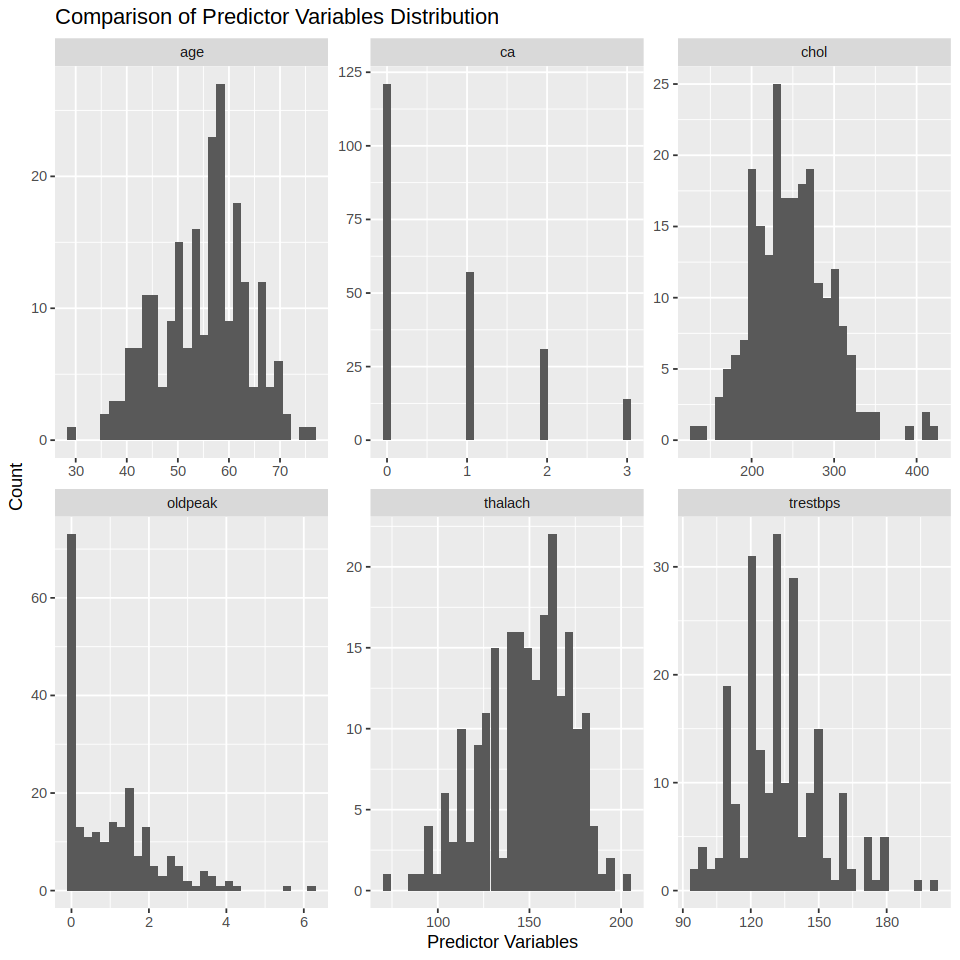

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)

heart_disease_train_predict <- select(heart_disease_train_filtered, age, trestbps, chol, thalach, oldpeak, ca)

long_data <- pivot_longer(heart_disease_train_predict, cols = everything(), names_to = "predictor_variables", values_to = "value")

heart_disease_train_hist <- ggplot(long_data, aes(x = value)) +
    geom_histogram(position = "identity") +
    facet_wrap(~predictor_variables, scales = "free") +
    labs(title = "Comparison of Predictor Variables Distribution", x = "Predictor Variables", y = "Count")

heart_disease_train_hist

### Methods 
For this study, we will conduct a classification prediction using the six non-categorical variables included in the above summary table. Categorical variables will not be used as they are not scaled and can lead to skewing the output. 

At this moment, we will likely create three classification models grouped by the testing data techniques. 

The first model will include `age`, `trestbps`, and `chol` as they are all either clinical or routine test data results. The second model will include `thalach` and `oldpeak` as they are exercise induced data results, and lastly `ca` will be in its own model as it refers to the fluoroscopy for coronary calcium results. After determining which predictors are meaningful and which ones are irrelevant, we will make a final classification model with all the meaningful predictors for better accuracy.

An example of the visualization of results would be to plot 2 meaningful predictor variables in a scatterplot, while the categorical variable 'num' will be colored. We can plot 2 versions of these, one using the actual class of the testing set for the color, while the other one uses the predicted class to color. Plot these side by side and we can compare and see if the coloring is similar then the prediction is accurate.

### Expected outcomes and significance

We expect to find a relationship between the predictor variables and the class variable 'num', that allows us to make a classification to predict patients' heart disease diagnoses


The findings of this classification can help diagnose heart disease quickly and more reliably, so immediate treatment can be given to patients even in an early stage of heart disease to prevent symptoms from worsening.


The results can lead to questions about the effects the predictors might have on the contraction of heart disease. It can also lead to questions about the relationship the predictors in the classification might have with other diseases.